In [1]:
import jax
import distrax
import numpyro
import jax.numpy as jnp
import jax.scipy as jsp
import matplotlib.pyplot as plt
import numpyro.distributions as dist

In [2]:
key = jax.random.PRNGKey(1234)

def exponential_normal_model(lamb, sigma):
    Z = numpyro.sample('latent_mu', dist.Exponential(rate=lamb))
    X = numpyro.sample('obs', dist.Normal(loc=Z, scale=sigma))
    return X
    

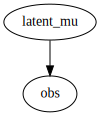

In [3]:
data = jnp.ones(10)
numpyro.render_model(exponential_normal_model, model_args=(data,data))

In [4]:
def joint_log_prob(model, lamb, sigma, X, Z):
    conditioned_model = numpyro.handlers.condition(model, data={'latent_mu': Z, 'obs': X})
    model_trace = numpyro.handlers.trace(conditioned_model).get_trace(lamb, sigma)
    
    Z_log_prob = model_trace['latent_mu']['fn'].log_prob(Z)
    Z_mask = jnp.logical_and(Z >= 0, jnp.isfinite(Z_log_prob))
    
    return jnp.where(Z_mask, Z_log_prob, -jnp.inf) + model_trace['obs']['fn'].log_prob(X)

# Example usage
lamb = 1.0
sigma = 1.0  
X = jnp.array(1.3)
Z = jnp.array(2.0)

joint_prob = jnp.exp(joint_log_prob(exponential_normal_model, lamb, sigma, X, Z))
print(f"Joint probability p(X={X}, Z={Z}) = {joint_prob}")

Joint probability p(X=1.2999999523162842, Z=2.0) = 0.04225897416472435


In [5]:
joint_prob = jnp.exp(joint_log_prob(exponential_normal_model, lamb, sigma, 1.3, -0.5))
print(f"Joint probability p(X={-0.5}, Z={Z}) = {joint_prob}")

Joint probability p(X=-0.5, Z=2.0) = 0.0


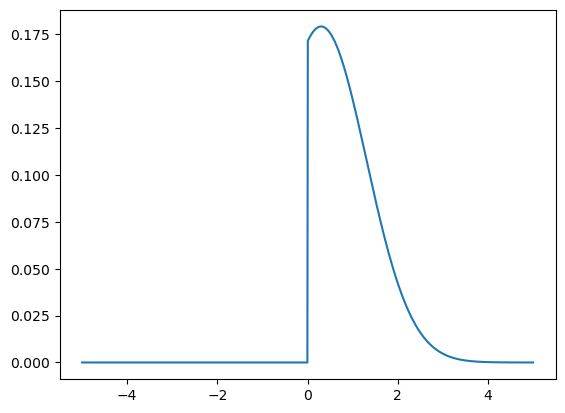

In [6]:
Z_range = jnp.linspace(-5,5, 1000)
prob_range = jnp.exp(joint_log_prob(exponential_normal_model, lamb, sigma, X, Z_range))
plt.plot(Z_range, prob_range)